In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle as pkl

In [3]:
df_aapl = pd.read_csv("AAPL.csv")
df_googl = pd.read_csv("GOOGL.csv")
df_meta = pd.read_csv("META.csv")
df_nvda = pd.read_csv("NVDA.csv")
df_tsla = pd.read_csv("TSLA.csv")
df_aapl["Date"] = pd.to_datetime(df_aapl["Date"], format="%Y-%m-%d")
df_googl["Date"] = pd.to_datetime(df_googl["Date"], format="%Y-%m-%d")
df_meta["Date"] = pd.to_datetime(df_meta["Date"], format="%Y-%m-%d")
df_nvda["Date"] = pd.to_datetime(df_nvda["Date"], format="%Y-%m-%d")
df_tsla["Date"] = pd.to_datetime(df_tsla["Date"], format="%Y-%m-%d")
df_aapl["Volume"] = df_aapl["Volume"].astype(float)
df_googl["Volume"] = df_googl["Volume"].astype(float)
df_meta["Volume"] = df_meta["Volume"].astype(float)
df_nvda["Volume"] = df_nvda["Volume"].astype(float)
df_tsla["Volume"] = df_tsla["Volume"].astype(float)
df = pd.merge(df_aapl, df_googl, on="Date", suffixes=("", "_googl"))
df = pd.merge(df, df_meta, on="Date", suffixes=("", "_meta"))
df = pd.merge(df, df_nvda, on="Date", suffixes=("", "_nvda"))
df = pd.merge(df, df_tsla, on="Date", suffixes=("_aapl", "_tsla"))

In [4]:
pd.options.mode.chained_assignment = None  # default='warn'
split = df["Date"][(len(df["Date"])*15)//20]
names = df.columns
y_names = ["Date"]
for val in names:
    if val[0] == "O" or val[0] == "C":
        y_names.append(val)
no_date = names[1:]
no_date_y = y_names[1:]
X = df.copy()
y = df.copy()[y_names]
X_train = pd.DataFrame(columns=X.columns)
X_test = pd.DataFrame(columns=X.columns)
X_test["X_date"] = pd.Series(dtype=X["Date"].dtype)
X_train = X[:100]
X_train["X_date"] = X["Date"][99]
prev_val = X["Date"][99]
for val in X["Date"][100:-10]:
    if val < split:
        X_train_new = X_train[X_train["X_date"] == prev_val][1:]
        X_train_new = pd.concat([X_train_new, X[X["Date"] == val]])
        X_train_new["X_date"] = val
        X_train = pd.concat([X_train, X_train_new])
        prev_val = val
    elif val == split:
        X_test = X_train[X_train["X_date"] == prev_val][1:]
        X_test = pd.concat([X_test, X[X["Date"] == val]])
        X_test["X_date"] = val
        prev_val = val
    else:
        X_test_new = X_test[X_test["X_date"] == prev_val][1:]
        X_test_new = pd.concat([X_test_new, X[X["Date"] == val]])
        X_test_new["X_date"] = val
        X_test = pd.concat([X_test, X_test_new])
        prev_val = val
X_train = X_train.groupby("X_date").agg(lambda x: list(x))
X_test = X_test.groupby("X_date").agg(lambda x: list(x))
y_train = pd.DataFrame(columns=y.columns)
y_train["X_date"] = pd.Series(dtype=y["Date"].dtype)
y_test = pd.DataFrame(columns=y.columns)
y_test["X_date"] = pd.Series(dtype=y["Date"].dtype)
y_train = y[100:110]
y_train["X_date"] = y["Date"][99]
prev_val = y["Date"][99]
for val in y["Date"][100:-10]:
    if val < split:
        y_train_new = y_train[y_train["X_date"] == prev_val][1:]
        y_train_new = pd.concat([y_train_new, y[y["Date"] == val]])
        y_train_new["X_date"] = val
        y_train = pd.concat([y_train, y_train_new])
        prev_val = val
    elif val == split:
        y_test = y_train[y_train["X_date"] == prev_val][1:]
        y_test = pd.concat([y_test, y[y["Date"] == val]])
        y_test["X_date"] = val
        prev_val = val
    else:
        y_test_new = y_test[y_test["X_date"] == prev_val][1:]
        y_test_new = pd.concat([y_test_new, y[y["Date"] == val]])
        y_test_new["X_date"] = val
        y_test = pd.concat([y_test, y_test_new])
        prev_val = val
y_train = y_train.groupby("X_date").agg(lambda x: list(x))
y_test = y_test.groupby("X_date").agg(lambda x: list(x))

In [5]:
def create_model(seed, num_neurons, drop_rate, activations):
    tf.random.set_seed(seed)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(2500,)))
    model.add(tf.keras.layers.BatchNormalization())
    for i in range(min(len(num_neurons), len(activations))):
        model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=0)))
        model.add(tf.keras.layers.SimpleRNN(num_neurons[i],  activation=activations[i]))
    if drop_rate > 0.0:
        model.add(tf.keras.layers.Dropout(rate=drop_rate))
    model.add(tf.keras.layers.Dense(100))
    model.compile(optimizer="Adam", loss="mse")
    return model

def use_model(seed, num_neurons=[10], drop_rate=0.0, activations=["relu"]):
    model = create_model(seed, num_neurons, drop_rate, activations)
    history = fit_mod(X_train, y_train, model)
    loss = evaluate_mod(X_test, y_test, model)
    return (model, history, loss)

def fit_mod(X_train, y_train, model):
    y_train_used = np.array(y_train[:][no_date_y].values.tolist())
    y_train_used = y_train_used.reshape((len(y_train_used), 100))
    X_train_used = np.array(X_train[:][no_date].values.tolist())
    X_train_used = X_train_used.reshape((len(X_train_used), 2500))
    return model.fit(X_train_used, y_train_used, epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss", patience=15)])

def predict_mod(X_test, model):
    X_test_used = np.array(X_test[:][no_date].values.tolist())
    X_test_used = X_test_used.reshape((len(X_test_used), 2500))
    return model.predict(X_test_used, batch_size=1)

def evaluate_mod(X_test, y_test, model):
    y_test_used = np.array(y_test[:][no_date_y].values.tolist())
    y_test_used = y_test_used.reshape((len(y_test_used), 100))
    return mean_squared_error(predict_mod(X_test, model), y_test_used) 


def grid_search(num_seeds=2, num_neurons_lst = [[10]], drop_rate_lst = [0.0], activations_lst = [["relu"]]):
    models = []
    histories = []
    losses = []
    min_loss = float("inf")
    min_loss_index = -1
    min_loss_params = [None, None, None, None]
    i = 0
    np.random.seed = 42
    for i in range(num_seeds):
        seed = np.random.randint(1,100)
        for num_neurons in num_neurons_lst:  
            for activations in activations_lst:
                if len(activations) == len(num_neurons):
                    for drop_rate in drop_rate_lst:
                        model, history, loss = use_model(seed, num_neurons, drop_rate, activations)
                        models.append(model)
                        histories.append(history)
                        losses.append(loss)
                        if loss < min_loss:
                            min_loss = loss
                            min_loss_index = i
                            min_loss_params = [seed, num_neurons, drop_rate, activations]
                        i += 1
    return (models, histories, losses, min_loss_index, min_loss_params)

In [7]:
def create_regressor(n_estimators=10, max_depth=15, eta=0.1):
    return MultiOutputRegressor(xgb.XGBRegressor(objective="reg:squarederror", n_estimators=n_estimators, max_depth=max_depth, eta=eta))

def fit_regress(X_train, y_train, model):
    y_train_used = np.array(y_train[:][no_date_y].values.tolist())
    y_train_used = y_train_used.reshape((len(y_train_used), 100))
    X_train_used = np.array(X_train[:][no_date].values.tolist())
    X_train_used = X_train_used.reshape((len(X_train_used), 2500))
    return model.fit(X_train_used, y_train_used)

def predict_regress(X_test, model):
    X_test_used = np.array(X_test[:][no_date].values.tolist())
    X_test_used = X_test_used.reshape((len(X_test_used), 2500))
    return model.predict(X_test_used)

def evaluate_regress(X_test, y_test, model):
    y_test_used = np.array(y_test[:][no_date_y].values.tolist())
    y_test_used = y_test_used.reshape((len(y_test_used), 100))
    return mean_squared_error(predict_regress(X_test, model), y_test_used) 

def regressor_grid(n_estimators_lst=[1000], max_depth_lst=[15], eta_lst=[0.1]):
    models = []
    histories = []
    losses = []
    min_loss = float("inf")
    min_loss_index = -1
    min_loss_params = [None, None, None]
    i = 0
    for num in n_estimators_lst:
        for depth in max_depth_lst:
            for eta in eta_lst:
                models.append(create_regressor(num, depth, eta))
                histories.append(fit_regress(X_train, y_train, models[-1]))
                loss = evaluate_regress(X_test, y_test, models[-1])
                losses.append(loss)
                if loss < min_loss:
                    min_loss = loss
                    min_loss_index = i
                    min_loss_params = [num, depth, eta]
                i += 1
    return (models, histories, losses, min_loss_index, min_loss_params)

In [8]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

y_train_used = np.array(y_train[:][no_date_y].values.tolist())
y_train_used = y_train_used.reshape((len(y_train_used), 100))
X_train_used = np.array(X_train[:][no_date].values.tolist())
X_train_used = X_train_used.reshape((len(X_train_used), 2500))
y_test_used = np.array(y_test[:][no_date_y].values.tolist())
y_test_used = y_test_used.reshape((len(y_test_used), 100))
X_test_used = np.array(X_test[:][no_date].values.tolist())
X_test_used = X_test_used.reshape((len(X_test_used), 2500))

X_scaler.fit_transform(X_train_used)
y_scaler.fit_transform(y_train_used)

X_scaled = X_scaler.transform(X_train_used)
y_scaled = y_scaler.transform(y_train_used)

X_test_scaled = X_scaler.transform(X_test_used)
y_test_scaled = y_scaler.transform(y_test_used)

def fit_regress_scaled(X_train_scaled, y_train_scaled, model):
    return model.fit(X_train_scaled, y_train_scaled)

def predict_regress_scaled(X_test_scaled, model):
    return model.predict(X_test_scaled)

def evaluate_regress_scaled(X_test_scaled, y_test_scaled, model):
    return mean_squared_error(predict_regress_scaled(X_test_scaled, model), y_test_scaled)


def regressor_grid_scaled(n_estimators_lst=[1000], max_depth_lst=[15], eta_lst=[0.1]):
    models = []
    histories = []
    losses = []
    min_loss = float("inf")
    min_loss_index = -1
    min_loss_params = [None, None, None]
    i = 0
    for num in n_estimators_lst:
        for depth in max_depth_lst:
            for eta in eta_lst:
                models.append(create_regressor(num, depth, eta))
                histories.append(fit_regress_scaled(X_scaled, y_scaled, models[-1]))
                loss = evaluate_regress_scaled(X_test_scaled, y_test_scaled, models[-1])
                losses.append(loss)
                if loss < min_loss:
                    min_loss = loss
                    min_loss_index = i
                    min_loss_params = [num, depth, eta]
                i += 1
                print(i)
    return (models, histories, losses, min_loss_index, min_loss_params)

def inverse_scaler_evaluate(model, X_test_scaled, y_test):
    return mean_squared_error(y_scaler.inverse_transform(predict_regress_scaled(X_test_scaled, model)), y_test_used)

C:\Users\barti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\barti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\barti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\barti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:918: Convergen

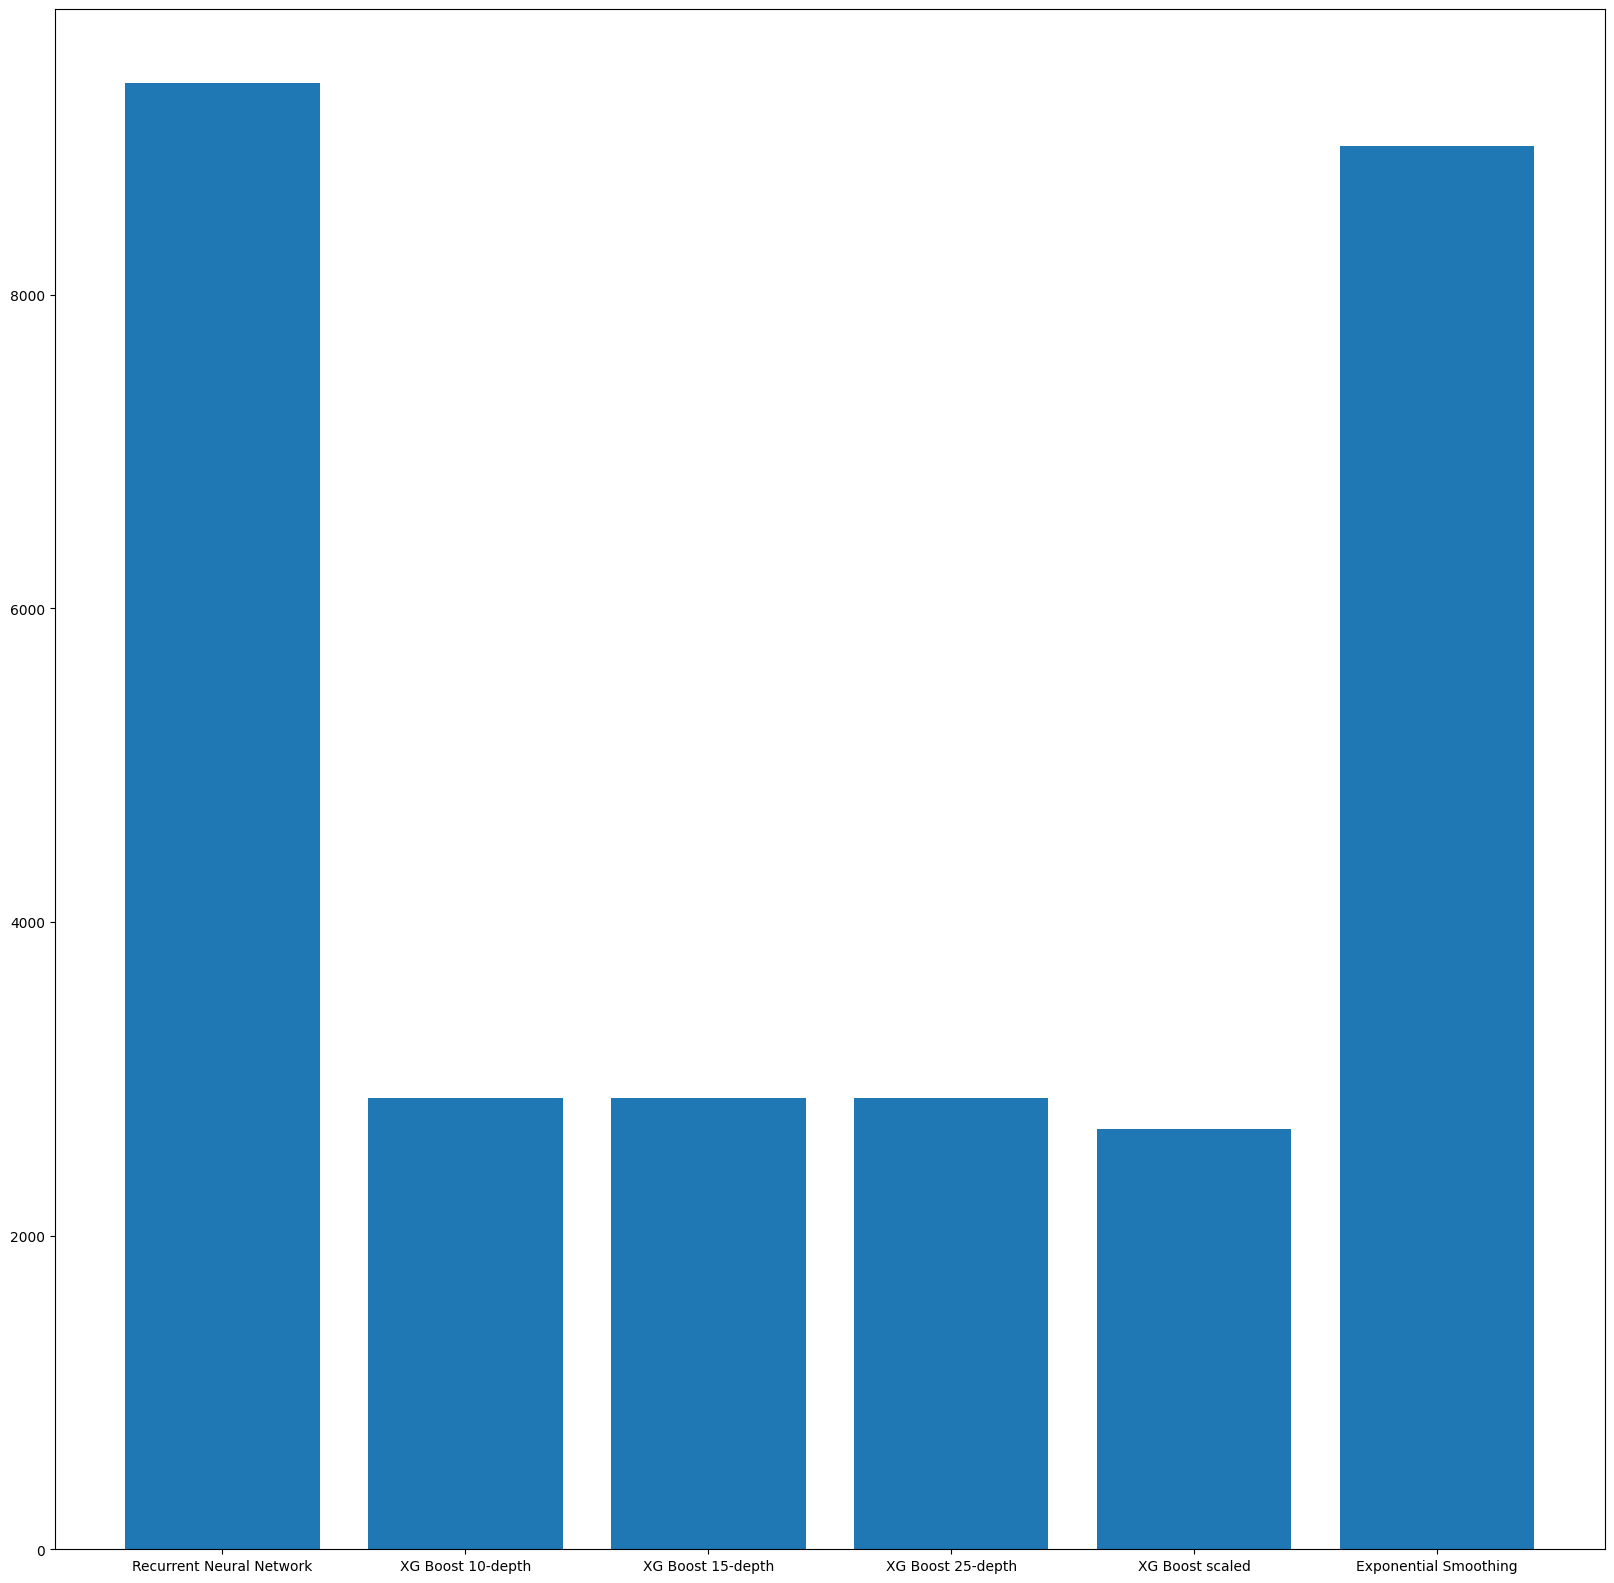

In [ ]:
"""
So there was an issue with loading the model, because apparently when loading the model from keras, it forgets that tensorflow exists altogether
and so even with the proposed online solution, which works for everybody else, it will not perform any calculations on my model because it has a
Lambda layer with a tensorflow function in it, and keras's load_model aspects just won't work with non builtin functions, so I would need to run
the code again, which for some reason even with the same seed does not give the same model, so the best RNN model is virtually lost forever,
however it was not the best model of them all anyway, so I'm glad I was able to beat it with an XGBoost model.
"""

#tf.keras.config.enable_unsafe_deserialization()
#Best_RNN_Model= tf.keras.models.load_model("my_model_1.keras", custom_objects={'tf': tf})
#RNN_error = evaluate_mod(X_test, y_test, Best_RNN_Model)
RNN_error = 9352.20
xgboost_model_1, xgboost_model_2, xgboost_model_3, xgboost_model_4 = (None, None, None, None)
with open("model_2.pkl", "rb") as f:
    xgboost_model_1 = pkl.load(f)
    xg1_error = evaluate_regress(X_test, y_test, xgboost_model_1)
with open("model_3.pkl", "rb") as f:
    xgboost_model_2 = pkl.load(f)
    xg2_error = evaluate_regress(X_test, y_test, xgboost_model_2)
with open("model_4.pkl", "rb") as f:
    xgboost_model_3 = pkl.load(f)
    xg3_error = evaluate_regress(X_test, y_test, xgboost_model_3)
with open("model_5.pkl", "rb") as f:
    xgboost_model_4 = pkl.load(f)
    xg4_error = inverse_scaler_evaluate(xgboost_model_4, X_test_scaled, y_test_scaled)
y_model = y[y["Date"] < split][no_date_y].apply(lambda x: ExponentialSmoothing(x, seasonal_periods=250, seasonal="additive", trend="additive", damped_trend=True))
y_fitted = []
y_forecasted = []
for val in y_model:
    y_fitted.append(val.fit())
    y_forecasted.append(y_fitted[-1].forecast(steps=len(y[y["Date"] >= split])))
    #print(y_forecasted)
error = sum(mean_squared_error(y_forecasted[i], y[y["Date"] >= split][y.columns[i + 1]]) for i in range(10))/10
plt.figure(figsize=[20, 20])
plt.bar(["Recurrent Neural Network", "XG Boost 10-depth", "XG Boost 15-depth", "XG Boost 25-depth", "XG Boost scaled" , "Exponential Smoothing"], [RNN_error, xg1_error, xg2_error, xg3_error, xg4_error, error])
plt.show()

"""
I also just realized that in my previous analysis when doing the exponential smoothing I was using the wrong value for the MSE
I was accidentally adding the MSE of the 10 variables together, but forgetting to divide by 10, after correcting this, it is much more reasonable
and is actually slightly better than the RNN that I made anyway.
"""

This analysis shows that the best model for five of the most popular tech stock prices is the Scaled XG Boost algorithm on 15 estimators, maximum depth of 25, with a learning rate of 0.3.  I believe that if I used 1000 estimators it could have been much much better, however, since it takes approximately 1.5 to 5 minutes to run each estimator depending on the hyperparameters, then it could be said to run for at least 25 hours straight, for which I do not have the cpu power, nor the google colab ability to run the code for that long to train the xg boost algorithm, in addition, with that many estimators, it could potentially overfit the training data, and be useless anyway.

The analysis shows that the average dollar amount wrong in the prediction is approximately $50 off the correct price, based on MSE.  Also, the way I predicted was by using the previous 100 days of data from all 5 variables inside each of the 5 datasets, and tried to predict specifically the Open and Close values for the following 14 days on the 5 datasets.